# Imports

In [308]:
import pandas as pd
import numpy as np
from scipy import sparse
import json
from tabulate import tabulate

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import sklearn.metrics as metr
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import TruncatedSVD

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgb
import xgboost
import lightgbm
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Classes and Functions
The following functions and classes are split up in several sections, since our project consists of several parts:
- Data Preparation: These functions prepare the JSON data for the machine learning pipeline.
- Pipeline Classes: Each step in the pipeline has to be a class which can fit and transform its input. This section consists of those classes.
- Training a Pipeline: One function that converts the strings that represents the steps in the pipeline to functions; another function that will be run to train, test and evaluate the model.
- Evaluation and Statistical Metrics: Functions that concern the evaluation of the model trained in the pipeline.

### Data Preparation

In [171]:
def split_train_test(submissions,train_set_fraction,randomize=True):
    ''' Function for splitting data in training and test set
    
    =========================== ===============================================
    Parameter                   Description
    =========================== ===============================================
    "submissions"               The data that needs to be split up.
    "train_set_fraction"        The fraction of the data that needs to be in 
                                the training set. 
    "randomize"                 Whether the order of the data should be 
                                shuffled.
    =========================== ===============================================
    '''
    data = []
    for submission in submissions:
        text = submission['title'] + '\n' + submission['selftext']
        title = submission['title']
        body = submission['selftext']
        label = submission['link_flair_text']
        comment_influx = submission['comment_influx']
        comment_text = submission['comment_toplevel_text']
        data.append([[text,comment_influx,comment_text,title,body],label])
    if(randomize): np.random.shuffle(data)
    trainsize = round(len(data) * train_set_fraction)

    train_set = [entry[0] for entry in data[:trainsize]]
    test_set = [entry[0] for entry in data[trainsize:]]
    train_labels = [entry[1] for entry in data[:trainsize]]
    test_labels = [entry[1] for entry in data[trainsize:]]
    return train_set, test_set, train_labels, test_labels

In [172]:
def equal_split_train(submissions,amount_per_group, randomize=True):
    ''' Function for splitting data in training and test set
    
    =========================== ===============================================
    Parameter                   Description
    =========================== ===============================================
    "submissions"               The data that needs to be split up.
    "amount_per_group"          The amount of observations that need to be in 
                                each class of the training set. 
    "randomize"                 Whether the order of the data should be 
                                shuffled.
    =========================== ===============================================
    '''
    data = []
    for submission in submissions:
        text = submission['title'] + '\n' + submission['selftext']
        title = submission['title']
        body = submission['selftext']
        label = submission['link_flair_text']
        comment_influx = submission['comment_influx']
        comment_text = submission['comment_toplevel_text']
        data.append([[text,comment_influx,comment_text,title,body],label])
    if(randomize): np.random.shuffle(data)
    
    labels = ['Book', 'Gaming', 'Movies &amp; Shows', 'Music', 'Neat']
    train_indices = [[],[],[],[],[]]
    test_indices = []    
    
    for i in range(len(data)):
        for u in range(len(labels)):
            if(data[i][1] == labels[u]):
                if(len(train_indices[u]) < amount_per_group):
                    train_indices[u].append(i)
                else:
                    test_indices.append(i)
    
    # flatten list of train indices
    train_indices_flat = []
    for label_indices in train_indices:
        for index in label_indices:
            train_indices_flat.append(index)
    
    train_set = [data[submission_index][0] for submission_index in train_indices_flat]
    test_set = [data[submission_index][0] for submission_index in test_indices]
    train_labels = [data[submission_index][1] for submission_index in train_indices_flat]
    test_labels = [data[submission_index][1] for submission_index in test_indices]
    return train_set, test_set, train_labels, test_labels

### Pipeline classes

In [4]:
class Stemmer(BaseEstimator):
    '''
    A stemmer that implements fit and transform so that it can be used in a pipeline.
    '''
    def __init__(self):
        self.l = PorterStemmer()
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = map(lambda text:  ' '.join([self.l.stem(word.lower()) for word in text.split()]), x)
        x = np.array(list(x))
        return x

In [7]:
class ToDense(BaseEstimator):
    '''
    A class for converting sparse matrices to dense matrices. For use in a pipeline. 
    '''
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        return x.toarray()

In [8]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [173]:
def create_dataframe(raw_data):
    '''
    This function takes in raw_data that has been extracted from reddit JSONs, and it converts it to a 
    pandas dataframe –> ready to be used by a pipeline. 
    
    =========================== ===============================================
    Parameter                   Description
    =========================== ===============================================
    "raw_data"                  Data to be converted to standard form of pandas
                                dataframe.
    =========================== ===============================================
    '''
    
    data_dict = {"comment_influx": np.array([raw_data[idx][1] for idx in range(len(raw_data))])} 
    first_frame_data = {"submission_text": np.array([raw_data[idx][0] for idx in range(len(raw_data))]),
                        
                        "comment_text": np.array([raw_data[idx][2] for idx in range(len(raw_data))]),
                        
                        "submission&comment_text": 
                        np.core.defchararray.add(np.array([raw_data[idx][0] for idx in range(len(raw_data))]), 
                                                 np.array([raw_data[idx][2] for idx in range(len(raw_data))])),
                        
                        "submission_body": np.array([raw_data[idx][4] for idx in range(len(raw_data))]),
                       
                        "submission_title": np.array([raw_data[idx][3] for idx in range(len(raw_data))])} 
    second_frame_data = data_dict["comment_influx"]
    return pd.concat([pd.DataFrame(first_frame_data), pd.DataFrame(second_frame_data)], axis=1)

### Training a pipeline

In [283]:
def create_transformer_list(feature_list):
    '''
    This function takes in a list of strings representing features to train models on.
    It uses that feature list to return a list containing the transforms to be used
    in a pipeline.
    
    =========================== ===============================================
    Parameter                   Description
    =========================== ===============================================
    "feature_list"              List of features to train a pipeline/model on.
    =========================== ===============================================
    '''
    transformer_list = []
    if "submission_text" in feature_list:
        transformer_list.append(('subtext', Pipeline([
                    ('selector', ItemSelector(key='submission_text')),
                    ('sm', sm),
                    ('tfidf_submissiontext', tfidf_submissiontext),
                ])))

    if "comment_text" in feature_list:
        transformer_list.append(('commenttext', Pipeline([
                    ('selector', ItemSelector(key='comment_text')),
                    ('sm', sm),
                    ('tfidf_commenttext', tfidf_commenttext),
                ])))
    
    if "submission_body" in feature_list:
        transformer_list.append(('subbody', Pipeline([
                    ('selector', ItemSelector(key='submission_body')),
                    ('sm', sm),
                    ('tfidf_submissionbody', tfidf_submissionbody),
                ])))
        
    if "submission_title" in feature_list:
        transformer_list.append(('subtitle', Pipeline([
                    ('selector', ItemSelector(key='submission_title')),
                    ('sm', sm),
                    ('tfidf_submissiontitle', tfidf_submissiontitle),
                ])))
    
    if "submission&comment_text" in feature_list:
        transformer_list.append(('subcommenttext', Pipeline([
                    ('selector', ItemSelector(key='submission&comment_text')),
                    ('sm', sm),
                    ('tfidf_alltext', tfidf_alltext),
                ])))
            
    if "comment_influx" in feature_list:
        transformer_list.append(('commentinflux', Pipeline([
                    ('selector', ItemSelector(key=keys)),            
                ])))

    return transformer_list    

In [175]:
def train_test_model(model, feature_list,
                     train_data, train_labels, test_data, test_labels):
    '''
    This function takes a list of models, features, feature weights, training/testing 
    data+labels and it returns a table showing the training and testing accuracy metrics
    for each model in the passed list.
    
    =========================== ===============================================
    Parameter                   Description
    =========================== ===============================================
    "model"                     A dictionary that maps model name strings to 
                                variables holding those model instantiations.
    "feature_list"              A list of strings of feature names to be used
                                for training. 
    "train_data"                Test data (pandas dataframe).
    "train_labels"              Testing labels.   
    "test_data"                 Test data (pandas dataframe).
    "test_labels"               Testing labels.            
    =========================== ===============================================
    '''
    transformer_list = create_transformer_list(feature_list)
    pipeline = Pipeline([
         ('union', FeatureUnion(
            transformer_list=transformer_list,
         ))
    ])
    
    if (model==("Gaussian Naive Bayes" or "Multinomial Naive Bayes")):
        pipeline.steps.append(['td', td])
        pipeline.steps.append(['model', model])
    else:
        pipeline.steps.append(['model', model])
    
    pipeline.fit(train_data,train_labels)
    train_score, test_score, test_predict, train_predict = model_evaluation(pipeline, train_data, train_labels,
                                                                      test_data, test_labels)
    
    pipeline_results = {'fitted_pipeline': pipeline, 'train_score': train_score, 'test_score': test_score,
                        'train_predict': train_predict, 'test_predict': test_predict, 'model': model}
    
    return pipeline_results
    

### Evaluation and Statistical Metrics

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            title = 'Confusion matrix, without normalization'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [237]:
def balanced_accuracy_score(y_true, y_pred, sample_weight=None,
                            adjusted=False):
    """"
    The function for balanced accuracy copied from a newer version of the sklearn
    module, since it wasn't available within the current module.
    """"
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn('y_pred contains classes not in y_true')
        per_class = per_class[~np.isnan(per_class)]
    score = np.mean(per_class)
    if adjusted:
        n_classes = len(per_class)
        chance = 1 / n_classes
        score -= chance
        score /= 1 - chance
    return score

In [291]:
def model_evaluation(pipeline, train_data, train_labels, test_data, test_labels):
    '''
    This function returns training and testing scores obtained from a pipeline trained and tested on 
    training and testing data+labels passed as input.
    
    =========================== ===============================================
    Parameter                   Description
    =========================== ===============================================
    "pipeline"                  The pipeline to use to obtain performance
                                metrics.
    "train_data"                Training data (pandas dataframe). 
    "train_labels"              Training labels.
    "test_data"                 Test data (pandas dataframe).
    "test_labels"               Testing labels.                                
    =========================== ===============================================
    '''
    
    train_score = pipeline.score(train_data,train_labels)
    train_predict = pipeline.predict(train_data)
    train_F1 = metr.f1_score(y_pred=train_predict,y_true=train_labels,average='weighted')
    train_bACC = balanced_accuracy_score(y_pred=train_predict,y_true=train_labels)
    train_recall_weighted = metr.recall_score(y_pred=train_predict,y_true=train_labels,average='weighted')
    
    y_pred = pipeline.predict(test_data)
    y_true = np.array(test_labels)
    test_score = metr.accuracy_score(y_true, y_pred)
    test_F1 = metr.f1_score(y_pred=y_pred,y_true=y_true,average='weighted')
    test_bACC = balanced_accuracy_score(y_pred=y_pred,y_true=y_true)
    
    print("Training accuracy: ", train_score)    
    print("Test accuracy: ", test_score)
    print("Training F1-score: ", train_F1)
    print("Test F1-score: ", test_F1)
    print("Training balanced accuracy: ", train_bACC)    
    print("Test balanced accuracy: ", test_bACC)
    
    labels = ['Book', 'Gaming', 'Movie and Show', 'Music', 'Neat']
    plot_confusion_matrix(y_true, y_pred, classes=np.array(labels), normalize=False)
    plot_confusion_matrix(y_true, y_pred, classes=np.array(labels), normalize=True)
    return train_score, test_score, y_pred, train_predict

# Loading and Splitting Data

In [17]:
#This cell reads JSON
submissions = []

with open('submissions_CasualConversation_filtered_with_comment_data.json', 'r') as save_file:
    saved_lines = save_file.readlines()
    for line in saved_lines:
        json_line = json.loads(line)
        submissions.append(json_line)

In [447]:
balanced_training = False

# This cell selects the necessary data from the JSON and splits it into a train a test set based 
# on the 'split' variable below. To use: set balanced training to 'False'.
if not balanced_training:
    split = 0.8
    train_x, test_x, train_y, test_y = split_train_test(submissions,split)

In [435]:
# This cell can be used to perform a train-test split, but with an equal distribution of posts
# amongst all classes. To use: set balanced training to 'True'.
if balanced_training:
    train_x, test_x, train_y, test_y = equal_split_train(submissions,amount_per_group=100)

In [449]:
# Makes the train_x, test_x, train_y and test_y usable in the pipeline.
x_train = create_dataframe(train_x)
y_train = train_y
x_test = create_dataframe(test_x)
y_test = test_y

In [450]:
def count_items_list(original_list):
    '''
    Count the labels for the training and test set using this function.
    '''
    nodupes_list = set(original_list)
    item_column = []
    count_column = []
    percentage_column = []

    for item in nodupes_list:
        item_column.append(item)
        count_column.append(original_list.count(item))
        percentage_column.append(count_column[-1]/len(original_list))
    
    count_df = pd.DataFrame(data={'item_name':item_column, 'count':count_column, 'percentage':percentage_column})
    count_df = count_df.sort_values(by='count',ascending=False)
    return count_df

In [451]:
count_items_list(y_train)

item_name  count  percentage
0               Music    808    0.386973
3  Movies &amp; Shows    523    0.250479
4              Gaming    503    0.240900
2                Book    144    0.068966
1                Neat    110    0.052682

In [445]:
count_items_list(y_test)

item_name  count  percentage
0               Music    939    0.445024
3  Movies &amp; Shows    545    0.258294
4              Gaming    515    0.244076
2                Book     71    0.033649
1                Neat     40    0.018957

## Setting Model Parameters, Model Variables and NLP-Preprocessing Variables

In [210]:
# default parameters for models
scoring='accuracy'
cv=1
n_jobs=1

In [211]:
from nltk.tokenize import regexp_tokenize
def our_tokenizer(s):
    return regexp_tokenize(s, "\w+")

In [367]:
### NLP-related preprocessing variables
sm = Stemmer()
tfidf_submissiontext = TfidfVectorizer(max_features=1000, tokenizer=our_tokenizer, ngram_range=(1, 3),analyzer='word', 
                          stop_words='english')
tfidf_commenttext = TfidfVectorizer(max_features=500, tokenizer=our_tokenizer, ngram_range=(1, 3),analyzer='word', 
                          stop_words='english')
tfidf_submissionbody = TfidfVectorizer(max_features=500, tokenizer=our_tokenizer, ngram_range=(1, 3),analyzer='word', 
                          stop_words='english')
tfidf_submissiontitle = TfidfVectorizer(max_features=100, tokenizer=our_tokenizer, ngram_range=(1, 3),analyzer='word', 
                          stop_words='english')
tfidf_alltext = TfidfVectorizer(max_features=1000, tokenizer=our_tokenizer, ngram_range=(1, 3),analyzer='word', 
                          stop_words='english')
tfidf_c = TfidfVectorizer(max_features=1000, analyzer='char')
svd = TruncatedSVD(n_components=100, n_iter=7)

### Model variables
lr = LogisticRegression()
xgb = XGBClassifier(max_depth=7, n_estimators=100, learning_rate=0.1, reg_alpha=3, max_leaves=70,min_child_weight=25)
# lgbm = lgb(max_depth=10, num_leaves=70, min_data_in_leaf=100, n_estimators=300, learning_rate=0.1, 
#            min_data=1, min_data_in_bin=1)
lgbm = lgb(max_depth=7, num_leaves=70, min_data_in_leaf=25, lambda_l1=3, learning_rate=0.1,n_estimators=100,objective='multiclassova')
gnb = GaussianNB()
mnb = MultinomialNB()
svm = SVC(kernel='linear')

### Miscellaneous variables for pipelines
td = ToDense()
keys = [i for i in range(24)]

# Results from Implementing Pipeline Models
Features:
- "comment_influx"
- "submission_text"
- "comment_text"
- "submission&comment_text"
- "submission_body"
- "submission_title"

Models:
- lr (linear regression)
- xgb (XGBoost)
- lgbm (Light Gradient Boosting Machine)
- gnb (Gaussian Naïve Bayes)
- mnb (Multinomial Naïve Bayes)
- svm (Support Vector Machine)

_Some examples of trained, tested and evaluated pipelines are given below_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training accuracy:  0.9765325670498084
Test accuracy:  0.9425287356321839
Training F1-score:  0.9763507263176949
Test F1-score:  0.9392987905941168
Training balanced accuracy:  0.9521712541033516
Test balanced accuracy:  0.8682222301074759
0.977 & 0.976 & 0.943 & 0.939


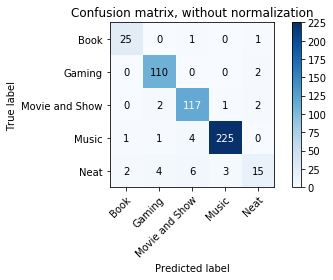

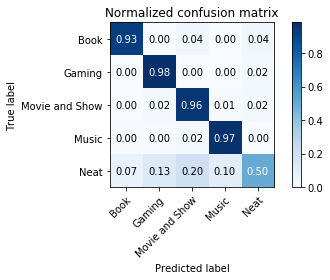

In [452]:
# Best performing model
model = lgbm
feature_list = ["submission_title", "submission_body"]
results = train_test_model(model=model, feature_list=feature_list, 
                          test_data=x_test, test_labels=y_test, train_data=x_train, train_labels=y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training accuracy:  0.928
Test accuracy:  0.8445497630331753
Training F1-score:  0.9286914982473323
Test F1-score:  0.8751510345630961
Training balanced accuracy:  0.9280000000000002
Test balanced accuracy:  0.8261172481747499
0.928 & 0.929 & 0.845 & 0.875


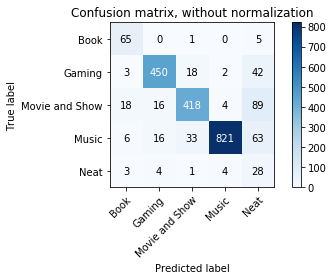

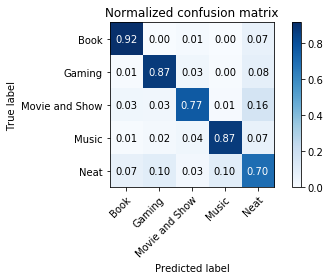

In [441]:
# Here a balanced training set was used
model = lgbm
feature_list = ["submission_title", "submission_body"]
results = train_test_model(model=model, feature_list=feature_list, 
                          test_data=x_test, test_labels=y_test, train_data=x_train, train_labels=y_train)

Training accuracy:  0.9798850574712644
Test accuracy:  0.9272030651340997
Training F1-score:  0.979829133490129
Test F1-score:  0.9249475938415546
Training balanced accuracy:  0.9691942145255886
Test balanced accuracy:  0.8565409954344381
0.98 & 0.98 & 0.927 & 0.925


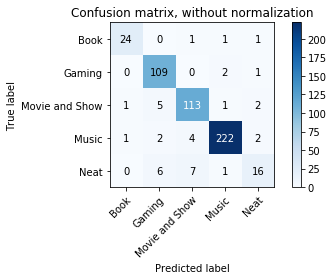

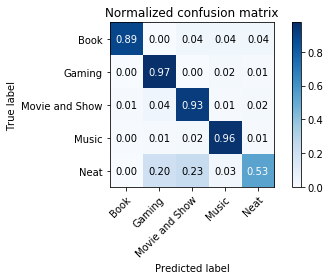

In [453]:
model = svm
feature_list = ["submission&comment_text"]
results = train_test_model(model=model, feature_list=feature_list, 
                          test_data=x_test, test_labels=y_test, train_data=x_train, train_labels=y_train)

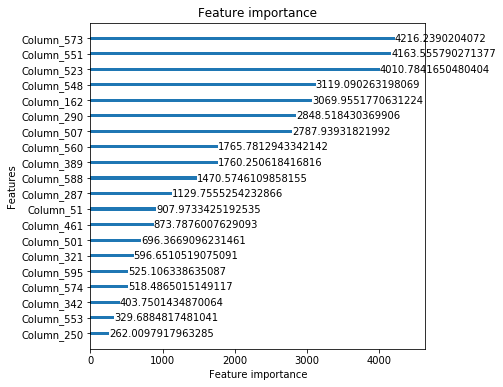

In [454]:
feature_importance = lightgbm.plot_importance(lgbm,grid=False, max_num_features=20,figsize=(6,6),importance_type='gain')

In [455]:
ticklabels = []
for label in feature_importance.get_ymajorticklabels():
    feature_column = int(label.get_text()[7:])
    if(feature_column < 500):
        feature = "body : " + tfidf_submissionbody.get_feature_names()[feature_column-500]
    elif(feature_column >= 500 and feature_column < 600):
        feature = "title : " + tfidf_submissiontitle.get_feature_names()[feature_column-500]
    print(feature_column)
    print(feature)
    label.set_text(s=feature)
    ticklabels.append(label)
feature_importance.set_yticklabels(ticklabels)
feature_importance.plot()

250
body : listen
553
title : netflix
342
body : read
574
title : songs
595
title : watch
321
body : play
501
title : album
461
body : watch
51
body : book
287
body : movi
588
title : tv
389
body : song
560
title : play
507
title : book
290
body : music
162
body : game
548
title : movi
523
title : game
551
title : music
573
title : song


[]

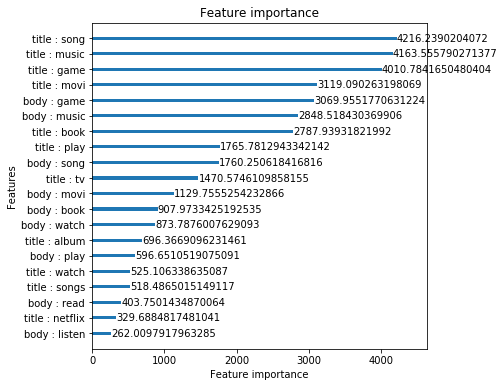

In [456]:
feature_importance.get_figure()

In [457]:
tfidf_submissiontitle.get_feature_names()

['2',
 'album',
 'ani',
 'anyon',
 'anyon els',
 'band',
 'best',
 'book',
 'day',
 'doe',
 'doe anyon',
 'doe anyon els',
 'don',
 'don t',
 'els',
 'enjoy',
 'favorit',
 'favourit',
 'feel',
 'feel like',
 'final',
 'finish',
 'friend',
 'game',
 'game play',
 'games',
 'good',
 'got',
 'great',
 'guy',
 'ha',
 'help',
 'idea',
 'just',
 'know',
 'let',
 'let talk',
 'life',
 'like',
 'listen',
 'listen music',
 'live',
 'll',
 'look',
 'lot',
 'love',
 'm',
 'make',
 'movi',
 'movie',
 'movies',
 'music',
 'need',
 'netflix',
 'new',
 'new music',
 'night',
 'old',
 'onli',
 'peopl',
 'play',
 'play game',
 'play video',
 'playlist',
 'r',
 'read',
 'realli',
 'recommend',
 'reddit',
 'right',
 'seen',
 'someon',
 'someth',
 'song',
 'songs',
 'start',
 'suggest',
 't',
 'talk',
 'talk music',
 'tell',
 'thi',
 'thing',
 'think',
 'thought',
 'time',
 'today',
 'tri',
 'tv',
 'use',
 'v',
 'video',
 'video game',
 'wa',
 'want',
 'watch',
 'watch movi',
 'whi',
 'work',
 'year']

In [330]:
tfidf_submissiontext.get_feature_names()

['1',
 '10',
 '100',
 '12',
 '15',
 '18',
 '2',
 '20',
 '2018',
 '3',
 '30',
 '4',
 '5',
 '50',
 '6',
 '7',
 '8',
 '80',
 '8c',
 '9',
 '90',
 'a7',
 'abl',
 'absolut',
 'act',
 'action',
 'actor',
 'actual',
 'ad',
 'add',
 'adult',
 'adventur',
 'af',
 'age',
 'ago',
 'album',
 'albums',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'amaz',
 'amazing',
 'amazon',
 'america',
 'american',
 'amp',
 'amp x200b',
 'ani',
 'ani game',
 'ani good',
 'ani song',
 'ani suggestions',
 'anim',
 'anoth',
 'answer',
 'anybodi',
 'anymore',
 'anyon',
 'anyon ani',
 'anyon els',
 'anyon els feel',
 'anyon want',
 'anyth',
 'app',
 'appreci',
 'aren',
 'aren t',
 'art',
 'artist',
 'artists',
 'ask',
 'attent',
 'author',
 'away',
 'awesom',
 'awesome',
 'b',
 'background',
 'bad',
 'band',
 'bare',
 'base',
 'basic',
 'bean',
 'beat',
 'beauti',
 'becam',
 'becaus',
 'becaus m',
 'becaus wa',
 'becom',
 'bed',
 'befor',
 'begin',
 'believ',
 'best',
 'best friend',
 'better',
 'big',
 'biggest',
 'bing

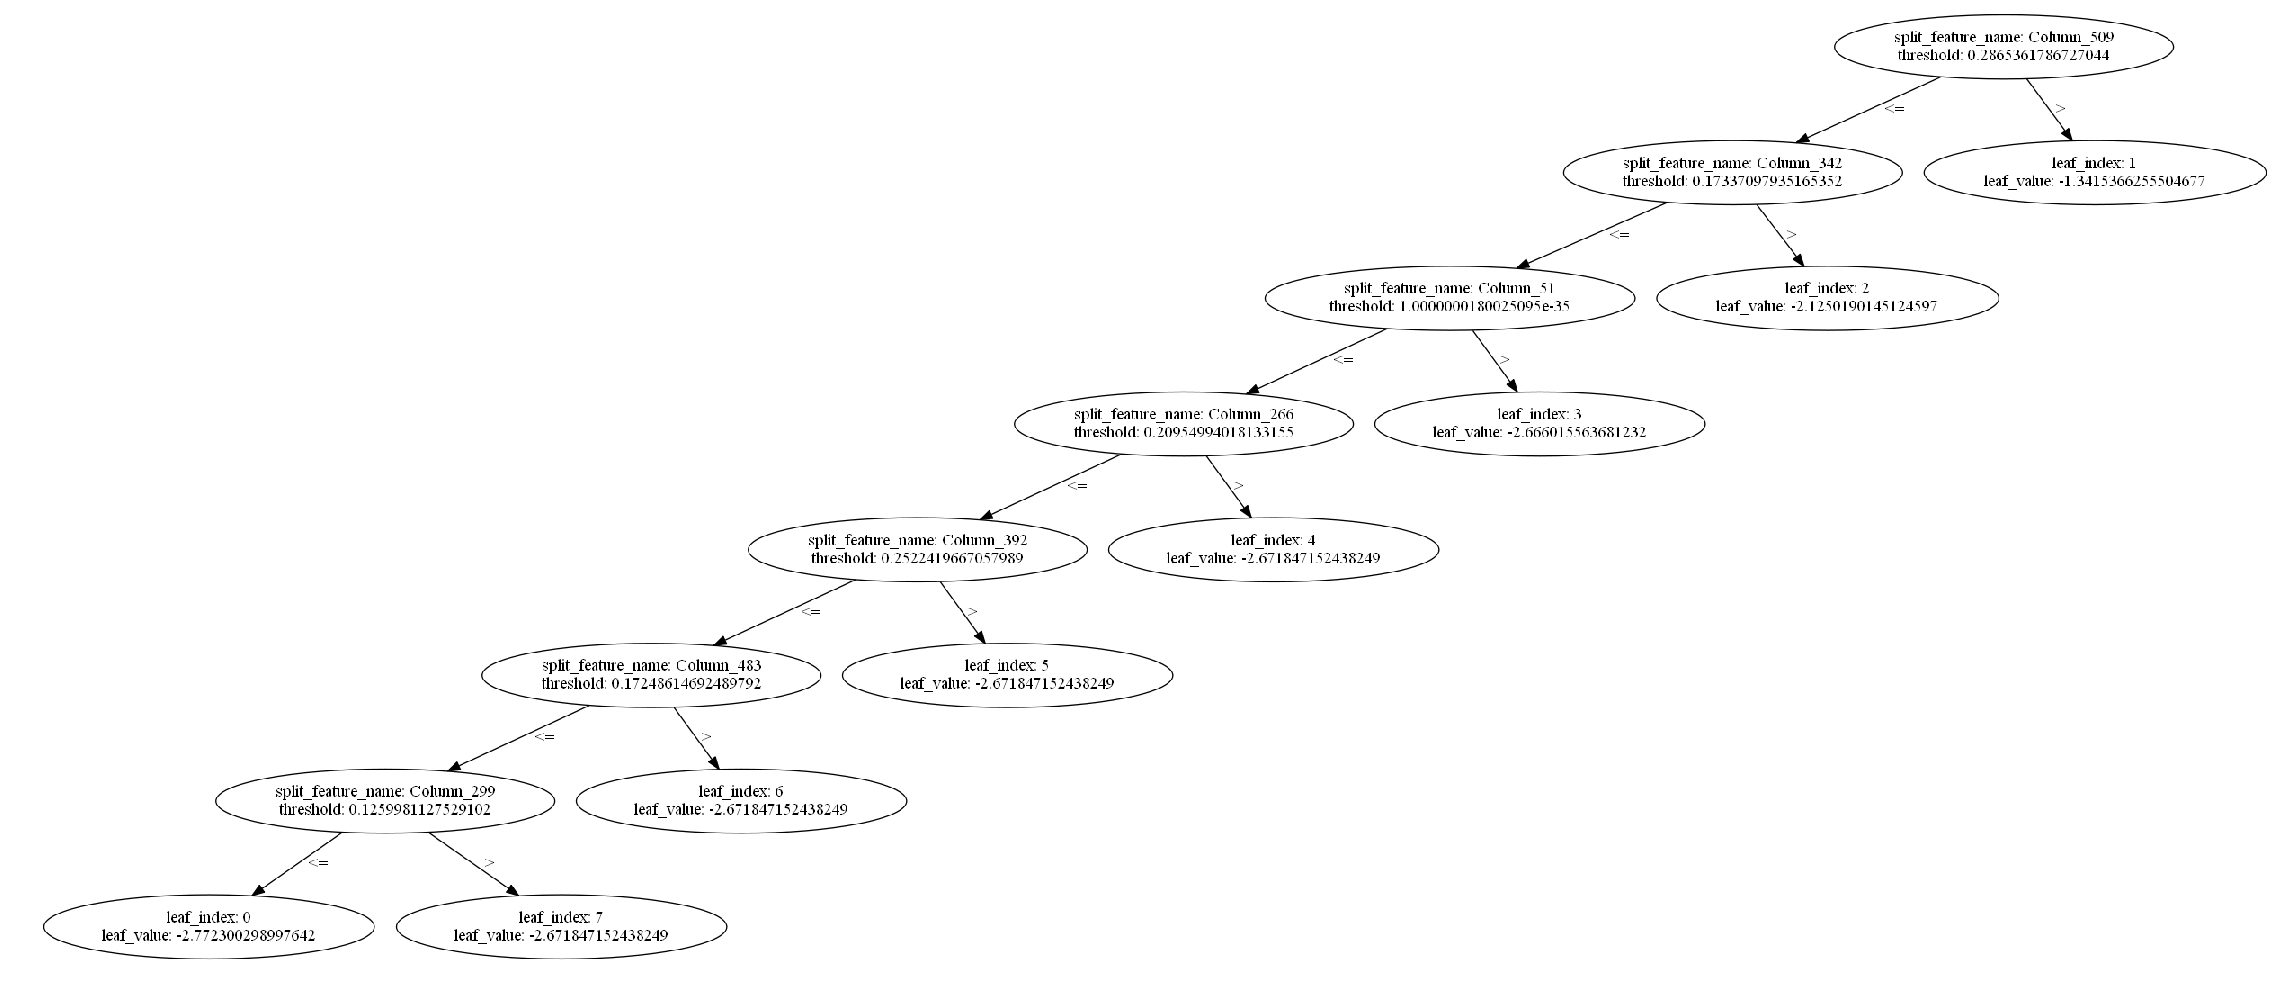

In [434]:
a_tree = lightgbm.plot_tree(lgbm,figsize=(40,40),tree_index=0)

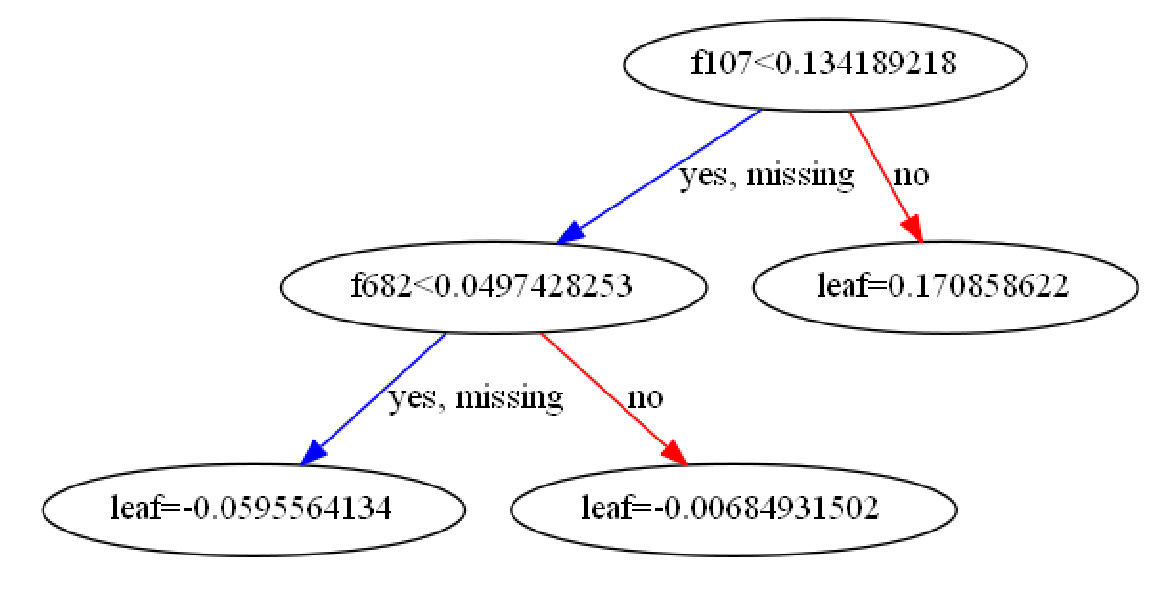

In [376]:
# Plotting a decision tree for XGBoost
fig = plt.figure(figsize=(20,20))
axes = plt.axes()
xgboost.plot_tree(xgb,ax=axes)